<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/nastia/reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Решение задачи регрессии с помощью нейронных сетей

Определение стоимости недвижимости из набора данных Boston Housing

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.


In [1]:
!pip install rdkit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from sklearn.preprocessing import FunctionTransformer
#from scipy.misc import toimage
%matplotlib inline

## Подготовка данных

**Загружаем данные**

In [2]:
all_data = pd.read_csv('processed_df.csv')
all_data = all_data.drop(all_data[all_data['CC50-MDCK, mmg/ml'] == 300].index)
X = all_data[["SMILES"]]
y = all_data["CC50-MDCK, mmg/ml"]
y2= all_data["IC50, mmg/ml"]


In [3]:
all_data[all_data['CC50-MDCK, mmg/ml'] == 300].shape

(0, 58)

In [4]:
all_data.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,#stars,...,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.0,...,0.0,0.0,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0
1,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,2.0,...,0.0,0.0,17.981,2.0,0.0,0.0,0.0,0.0,0.0,18.0
2,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,3.0,...,0.0,0.0,18.821,2.0,0.0,0.0,0.0,0.0,0.0,16.0
3,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,1.0,...,0.0,0.0,36.035,3.0,0.0,0.0,0.0,0.0,0.0,17.0
4,1013-Ya-179,26.6,500.0,18.796992,570.997,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CC[N+](CC)(CC)...,7.0,...,0.0,0.0,27.009,4.0,2.0,0.0,0.0,0.0,0.0,41.0


In [5]:
all_data.shape

(1069, 58)

In [6]:
X.head()

,SMILES
0,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
1,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
2,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2
3,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C
4,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CC[N+](CC)(CC)...


In [7]:
from rdkit import Chem
def RDKfingerPrint(mol_smi, **kwargs):
    mol = Chem.MolFromSmiles(mol_smi)
    desc_vec = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(AllChem.RDKFingerprint(mol, **kwargs), desc_vec)
    return desc_vec

In [8]:
fp =[]
for semp in all_data['SMILES']:
  fp.append(RDKfingerPrint(semp, maxPath=5))

fp = pd.DataFrame(fp)


X = fp#pd.merge(X, fp, left_index = True, right_index=True)

[10:09:45] Conflicting single bond directions around double bond at index 55.
[10:09:45]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [9]:
#X = X.drop(columns=  ["SMILES"])

In [10]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Просмотр данных**

In [12]:
min_y = y_train.min()
max_y = y_train.max()

In [13]:
print(y_train.min())
print(y_train.max())

0.031928
500.0


## Создаем нейронную сеть



In [14]:
model = Sequential()
model.add(Dense(987, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.1))
#model.add(Dense(100, activation='softmax'))
model.add(Dense(1))#, activation='sigmoid')) # sigmoid, т.к. данные от 0 до 1

In [15]:
print(model.summary()) # архитектура нашей модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 987)               2022363   
                                                                 
 dense_1 (Dense)             (None, 64)                63232     
                                                                 
 dense_2 (Dense)             (None, 1000)              65000     
                                                                 
 dense_3 (Dense)             (None, 64)                64064     
                                                                 
 dense_4 (Dense)             (None, 1000)              65000     
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 64)                3

**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [16]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## Обучаем нейронную сеть



In [17]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    validation_split=0.1,
                    verbose=2)

Epoch 1/30
23/23 - 2s - loss: 20311.4980 - mae: 86.5956 - val_loss: 10433.2578 - val_mae: 64.5900 - 2s/epoch - 97ms/step
Epoch 2/30
23/23 - 1s - loss: 9962.8301 - mae: 66.2782 - val_loss: 15429.4971 - val_mae: 101.7115 - 853ms/epoch - 37ms/step
Epoch 3/30
23/23 - 1s - loss: 9905.7568 - mae: 65.5163 - val_loss: 11031.9678 - val_mae: 58.6946 - 1s/epoch - 58ms/step
Epoch 4/30
23/23 - 2s - loss: 9476.7549 - mae: 62.1405 - val_loss: 11453.5088 - val_mae: 61.3923 - 2s/epoch - 76ms/step
Epoch 5/30
23/23 - 1s - loss: 7513.4946 - mae: 54.8127 - val_loss: 12612.7031 - val_mae: 64.6420 - 1s/epoch - 65ms/step
Epoch 6/30
23/23 - 1s - loss: 7594.1118 - mae: 54.4226 - val_loss: 8673.7852 - val_mae: 55.2828 - 1s/epoch - 51ms/step
Epoch 7/30
23/23 - 1s - loss: 7539.9917 - mae: 53.9773 - val_loss: 8126.4229 - val_mae: 55.0162 - 1s/epoch - 50ms/step
Epoch 8/30
23/23 - 1s - loss: 6473.1978 - mae: 49.7437 - val_loss: 11244.3984 - val_mae: 59.9035 - 1s/epoch - 53ms/step
Epoch 9/30
23/23 - 1s - loss: 6125.96

In [18]:
# Делаем прогноз. Возвращается копия предсказания в виде одномерного массива
x_test = np.asarray(x_test).astype(np.float32)
pred = model.predict(x_test).flatten()

9/9 [==============================] - 0s 9ms/step


In [19]:
from sklearn.metrics import mean_absolute_error
# Средний модуль отклонения
err = np.mean(abs(pred - y_test))
print(err)
mae = mean_absolute_error(y_test, pred)

64.3788576304023


In [20]:
err = sum(abs(pred - y_test)) / len(pred)
print(err) #вывести ошибку

64.37885763040231


In [21]:
# Предсказание vs правильный ответ
y_test = np.asarray(y_test).astype(np.float32)
for i in range(len(pred)):
  #print("Сеть сказала: ", round(pred[i],2), ", а верный ответ: ", round(y_test[i],2), ", разница: ", round(pred[i] - y_test[i],2))

SyntaxError: ignored

## Визуализация качества обучения

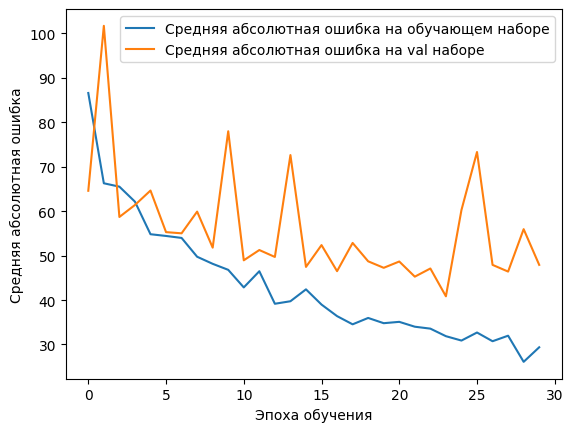

In [22]:
# Считаем графики ошибки
plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на val наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

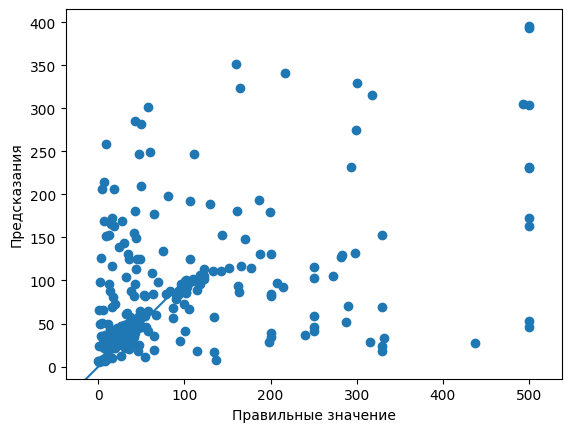

In [23]:
# Разброс предсказаний может показать перекос, если есть
plt.scatter(y_test, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

**Печатаем примеры результатов**

Гистограмма ошибок

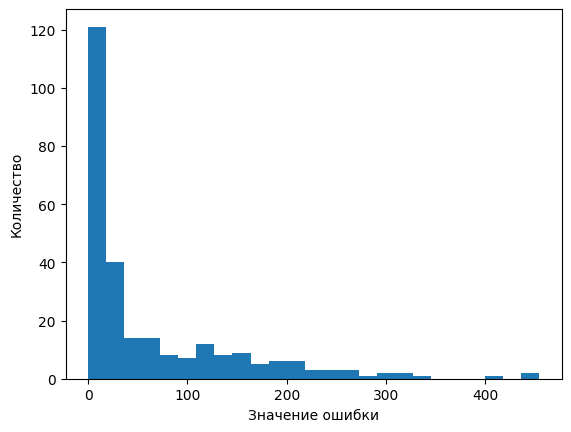

In [24]:
#Разность предсказанного и правильного ответа
error = pred - y_test

#Построение гистограммы
plt.hist(abs(error), bins = 25)
plt.xlabel("Значение ошибки")
plt.ylabel("Количество")
plt.show()